In [4]:
!pip install pandas scikit-learn vaderSentiment
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from google.colab import drive
!mkdir -p content/drive
drive.mount('content/drive')

Drive already mounted at content/drive; to attempt to forcibly remount, call drive.mount("content/drive", force_remount=True).


In [6]:
calls = pd.read_csv('/content/content/drive/MyDrive/hack/calls.csv')
reason= pd.read_csv('/content/content/drive/MyDrive/hack/reason.csv')
sentiments = pd.read_csv('/content/content/drive/MyDrive/hack/sentiment_statistics.csv')
test = pd.read_csv('/content/content/drive/MyDrive/hack/test.csv')
merged_data = pd.merge(calls, sentiments, on='call_id')
merged_data = pd.merge(merged_data, reason, on='call_id')


In [7]:
calls['call_start_datetime'] = pd.to_datetime(calls['call_start_datetime'])
calls['agent_assigned_datetime'] = pd.to_datetime(calls['agent_assigned_datetime'])
calls['call_end_datetime'] = pd.to_datetime(calls['call_end_datetime'])


In [8]:

# Calculate Handle Time (AHT)
calls['customer_handle_time'] = (calls['call_end_datetime'] - calls['agent_assigned_datetime']).dt.total_seconds() / 60  # In minutes

# Calculate Speed to Answer (AST)
calls['speed_to_answer'] = (calls['agent_assigned_datetime'] - calls['call_start_datetime']).dt.total_seconds() / 60  # In minutes
merged_data = pd.merge(calls, merged_data, on='call_id')


In [9]:

# Calculate averages
aht = calls['customer_handle_time'].mean()
ast = calls['speed_to_answer'].mean()

In [10]:

print(f'Average Handle Time (AHT): {aht:.2f} minutes')
print(f'Average Speed to Answer (AST): {ast:.2f} minutes')


Average Handle Time (AHT): 11.62 minutes
Average Speed to Answer (AST): 7.28 minutes


In [11]:
merged_data_new = merged_data.copy()
merged_data_new['primary_call_reason_cleaned'] = merged_data_new['primary_call_reason'].str.lower()
merged_data_new['primary_call_reason_cleaned'] = merged_data_new['primary_call_reason_cleaned'].str.strip()
merged_data_new.head()

reason.head()
merged_data_new['primary_call_reason_cleaned'] = merged_data_new['primary_call_reason_cleaned'].replace({
    'products and services': 'products & services',
    'voluntary   change': 'voluntary change',
    'post-flight': 'post flight',
    'check-in': 'check in',
    'digital   support': 'digital support',
    'digital  support': 'digital support',
    'mileage   plus': 'mileage plus',
    'mileage  plus': 'mileage plus',
    'traveler   updates': 'traveler updates',
    'traveler  updates': 'traveler updates',
    'voluntary  change': 'voluntary change',
    'voluntary  cancel': 'voluntary cancel',
    'other  topics': 'other topics',
})

In [12]:


call_type_aht = merged_data_new.groupby('primary_call_reason_cleaned')['customer_handle_time'].mean().sort_values(ascending=False)
print(call_type_aht)


primary_call_reason_cleaned
checkout               16.947564
mileage plus           16.592890
etc                    16.048319
post flight            15.548268
communications         13.778646
irrops                 13.085268
products & services    12.442677
voluntary cancel       12.031114
voluntary change       10.652563
upgrade                10.539080
check in                9.568803
unaccompanied minor     8.653846
schedule change         8.166895
seating                 7.916575
booking                 7.128934
traveler updates        6.553895
digital support         6.204898
other topics            5.834963
baggage                 5.560734
disability              4.868486
Name: customer_handle_time, dtype: float64


In [13]:
call_type_ast = merged_data_new.groupby('primary_call_reason_cleaned')['speed_to_answer'].mean().sort_values(ascending=False)
print(call_type_ast)


primary_call_reason_cleaned
checkout               12.078390
traveler updates       11.500534
unaccompanied minor    11.471154
seating                 9.513747
post flight             9.490531
etc                     9.071429
baggage                 9.034958
voluntary change        9.008112
voluntary cancel        8.991910
digital support         8.428571
disability              8.392060
mileage plus            6.016920
irrops                  6.001352
check in                5.930672
products & services     5.040816
upgrade                 4.974799
schedule change         4.013680
booking                 4.003792
communications          3.999479
other topics            3.979218
Name: speed_to_answer, dtype: float64


In [14]:

#Group the data by primary_call_reason_cleaned to get frequency and AHT
grouped_data = merged_data_new.groupby('primary_call_reason_cleaned').agg(
    call_count=('call_id', 'count'),  # Count of calls for each reason
    avg_handle_time=('customer_handle_time', 'mean')  # Average handle time
).reset_index()

#Identify the most and least frequent call reasons
most_frequent_reason = grouped_data.loc[grouped_data['call_count'].idxmax()]
least_frequent_reason = grouped_data.loc[grouped_data['call_count'].idxmin()]

# Extract the AHT values
aht_most_frequent = most_frequent_reason['avg_handle_time']
aht_least_frequent = least_frequent_reason['avg_handle_time']

#Calculate the percentage difference
percentage_diff = ((aht_most_frequent - aht_least_frequent) / aht_least_frequent) * 100

# Output results
print(f"Most Frequent Reason: {most_frequent_reason['primary_call_reason_cleaned']}")
print(f"Least Frequent Reason: {least_frequent_reason['primary_call_reason_cleaned']}")
print(f"AHT for Most Frequent Reason: {aht_most_frequent:.2f}")
print(f"AHT for Least Frequent Reason: {aht_least_frequent:.2f}")
print(f"Percentage Difference: {percentage_diff:.2f}%")


Most Frequent Reason: irrops
Least Frequent Reason: unaccompanied minor
AHT for Most Frequent Reason: 13.09
AHT for Least Frequent Reason: 8.65
Percentage Difference: 51.21%


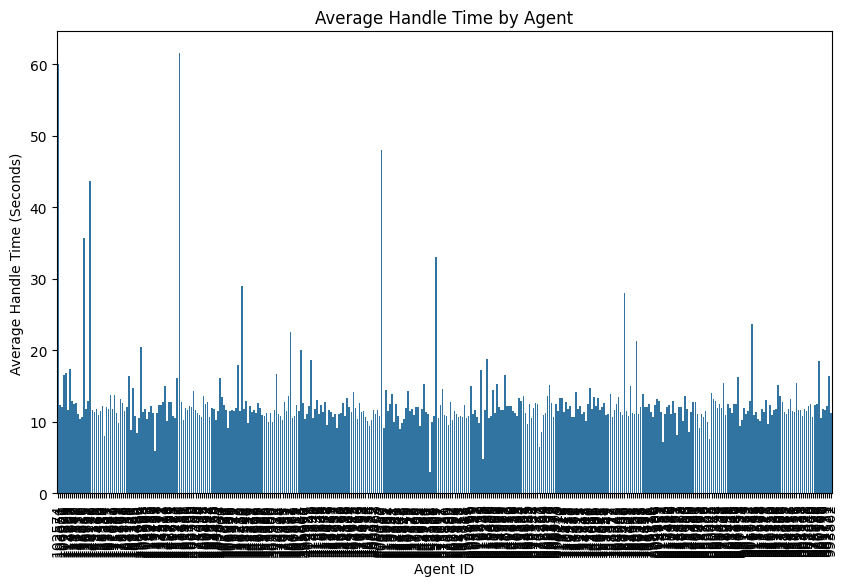

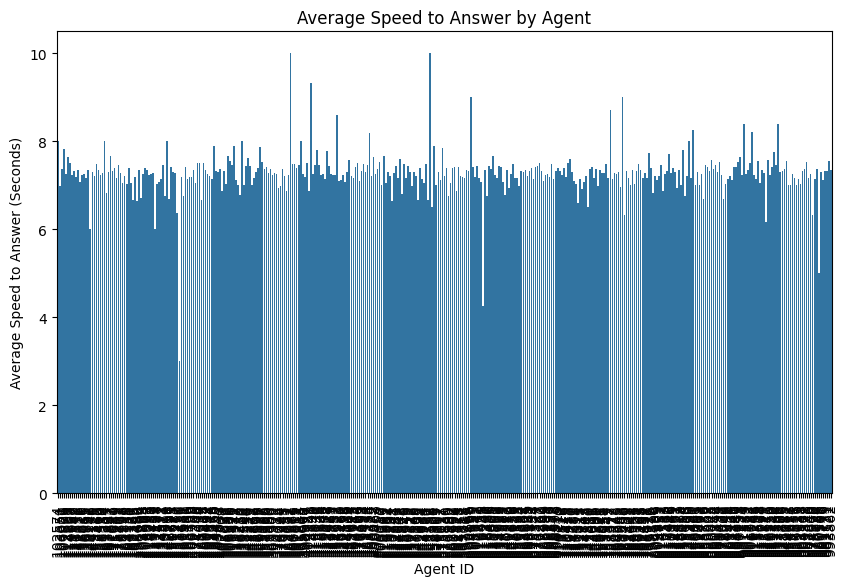

In [15]:
# Group by agent_id and calculate the average AHT and AST
agent_performance = merged_data_new.groupby('agent_id')[['customer_handle_time', 'speed_to_answer']].mean()

# Plotting AHT and AST per agent
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(x=agent_performance.index, y=agent_performance['customer_handle_time'])
plt.title('Average Handle Time by Agent')
plt.xlabel('Agent ID')
plt.ylabel('Average Handle Time (Seconds)')
plt.xticks(rotation=90)
plt.show()

# Similarly for AST
plt.figure(figsize=(10, 6))
sns.barplot(x=agent_performance.index, y=agent_performance['speed_to_answer'])
plt.title('Average Speed to Answer by Agent')
plt.xlabel('Agent ID')
plt.ylabel('Average Speed to Answer (Seconds)')
plt.xticks(rotation=90)
plt.show()


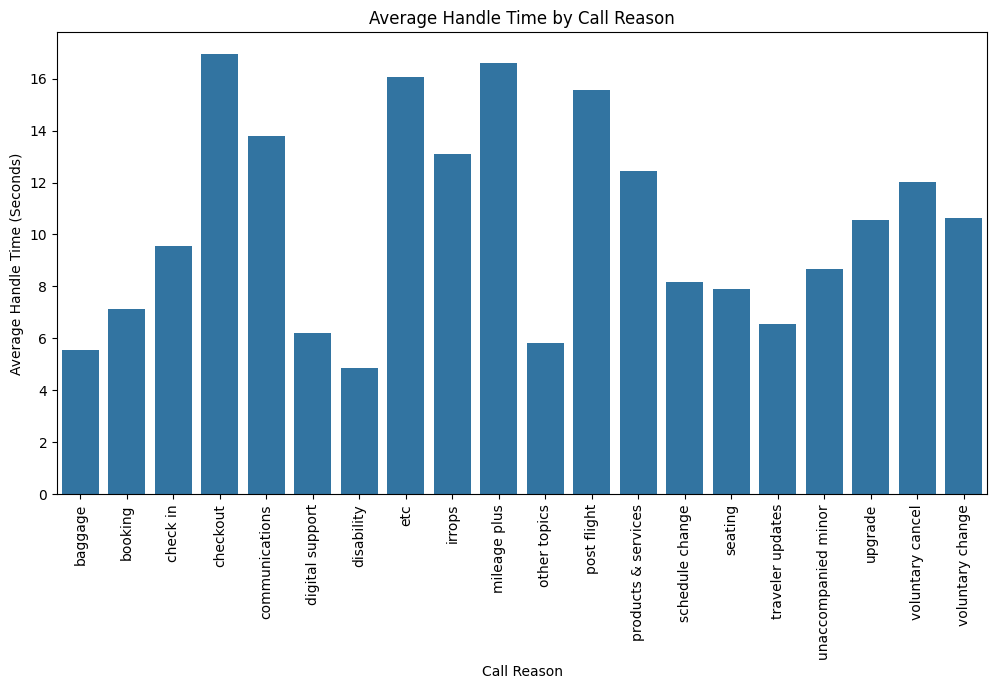

In [16]:
# Group by call reason and calculate the average AHT and AST
call_type_performance = merged_data_new.groupby('primary_call_reason_cleaned')[['customer_handle_time', 'speed_to_answer']].mean()

# Plot AHT by call reason
plt.figure(figsize=(12, 6))
sns.barplot(x=call_type_performance.index, y=call_type_performance['customer_handle_time'])
plt.title('Average Handle Time by Call Reason')
plt.xlabel('Call Reason')
plt.ylabel('Average Handle Time (Seconds)')
plt.xticks(rotation=90)
plt.show()


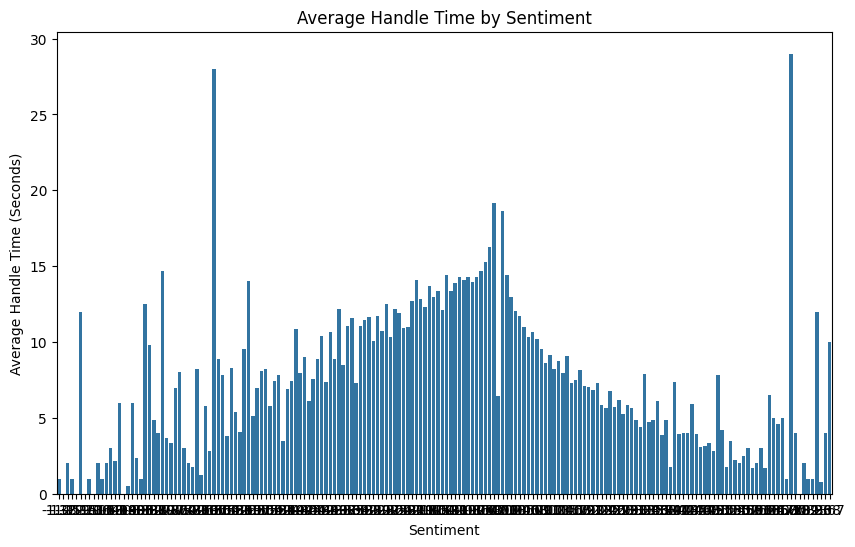

In [17]:
# Group by sentiment and calculate average AHT
sentiment_performance = merged_data.groupby('average_sentiment')[['customer_handle_time', 'speed_to_answer']].mean()

# Plot AHT by sentiment
plt.figure(figsize=(10, 6))
sns.barplot(x=sentiment_performance.index, y=sentiment_performance['customer_handle_time'])
plt.title('Average Handle Time by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Average Handle Time (Seconds)')
plt.show()


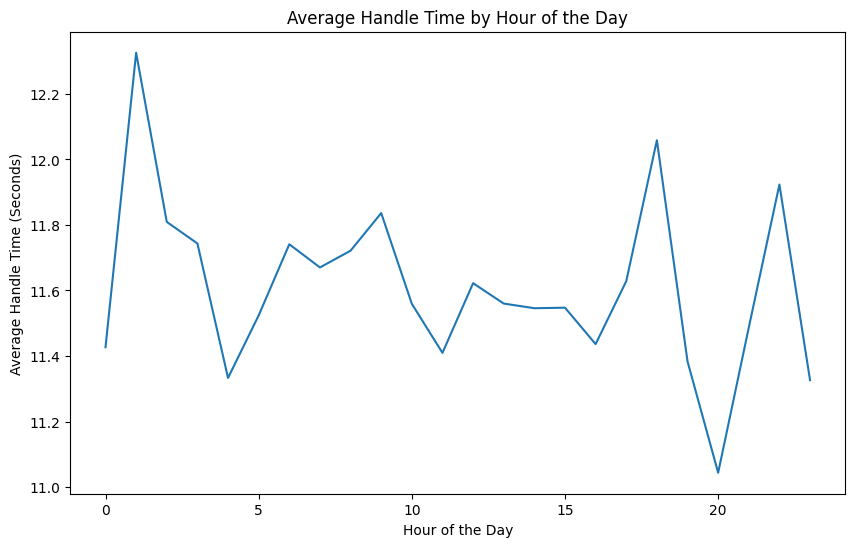

In [18]:
# Extract hour from call_start_datetime
merged_data_new['call_hour'] = pd.to_datetime(merged_data_new['call_start_datetime_x']).dt.hour

# Group by hour and calculate AHT and AST
hourly_performance = merged_data_new.groupby('call_hour')[['customer_handle_time', 'speed_to_answer']].mean()

# Plot AHT by hour
plt.figure(figsize=(10, 6))
sns.lineplot(x=hourly_performance.index, y=hourly_performance['customer_handle_time'])
plt.title('Average Handle Time by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Handle Time (Seconds)')
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

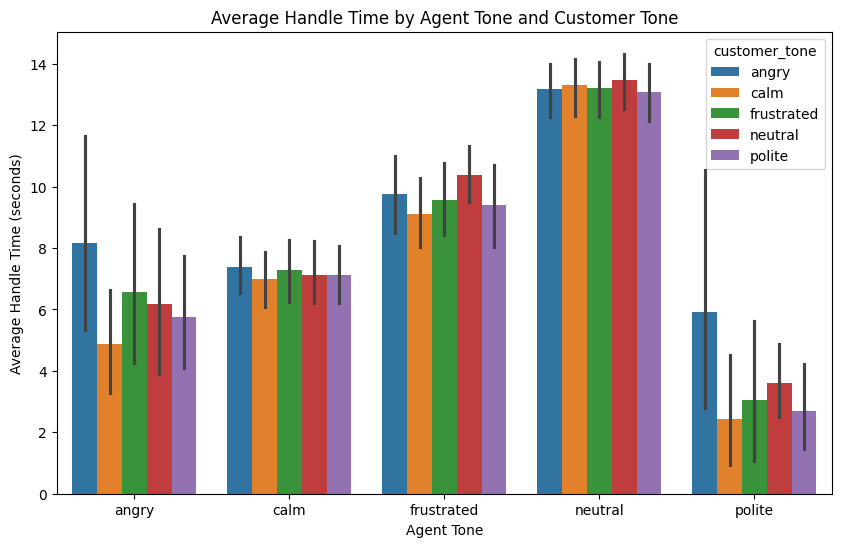

In [19]:
grouped_data_s = merged_data_new.groupby(['agent_tone', 'customer_tone', 'average_sentiment']).agg(
    avg_handle_time=('customer_handle_time', 'mean'),
    avg_waiting_time=('speed_to_answer', 'mean')
).reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='agent_tone', y='avg_handle_time', hue='customer_tone', data=grouped_data_s)
plt.title('Average Handle Time by Agent Tone and Customer Tone')
plt.xlabel('Agent Tone')
plt.ylabel('Average Handle Time (seconds)')
plt.show()

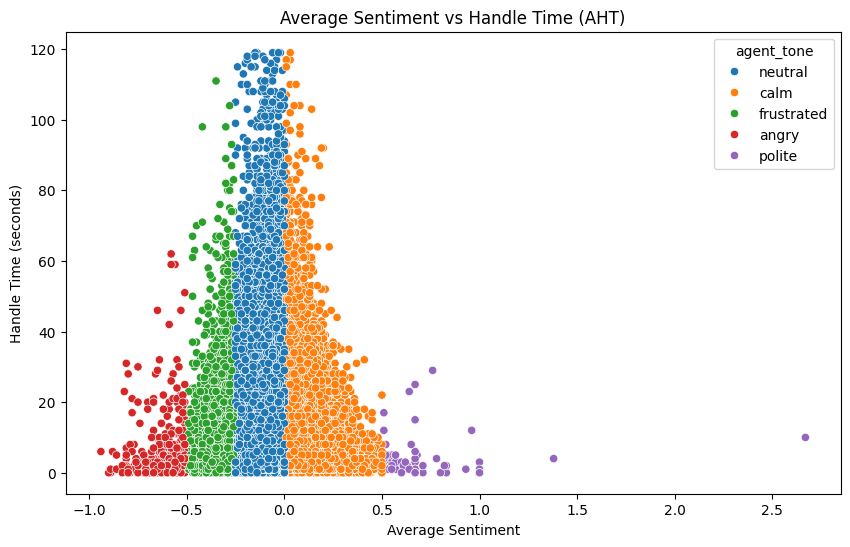

In [20]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='average_sentiment', y='customer_handle_time', hue='agent_tone', data=merged_data_new)
plt.title('Average Sentiment vs Handle Time (AHT)')
plt.xlabel('Average Sentiment')
plt.ylabel('Handle Time (seconds)')
plt.show()

In [21]:
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.decomposition import LatentDirichletAllocation

# # Preprocess transcripts (clean text)
# call_transcripts = merged_data_new['call_transcript_x'].fillna('')  # Fill NaN with empty string
# vectorizer = CountVectorizer(stop_words='english', max_features=1000)  # Convert transcripts to a matrix of token counts
# transcript_matrix = vectorizer.fit_transform(call_transcripts)

# # Perform topic modeling using LDA
# lda_model = LatentDirichletAllocation(n_components=10, random_state=42)  # 10 topics
# lda_model.fit(transcript_matrix)

# # Display topics and top words
# for index, topic in enumerate(lda_model.components_):
#     print(f"Top 10 words for Topic #{index}:")
#     print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
#     print("\n")


In [22]:
test.head()

,call_id
0,7732610078
1,2400299738
2,6533095063
3,7774450920
4,9214147168


In [23]:
merged_data_new.head()

,call_id,customer_id_x,agent_id,call_start_datetime_x,agent_assigned_datetime_x,call_end_datetime_x,call_transcript_x,customer_handle_time,speed_to_answer,customer_id_y,...,call_end_datetime_y,call_transcript_y,agent_id_y,agent_tone,customer_tone,average_sentiment,silence_percent_average,primary_call_reason,primary_call_reason_cleaned,call_hour
0,4667960400,2033123310,963118,2024-07-31 23:56:00,2024-08-01 00:03:00,2024-08-01 00:34:00,\n\nAgent: Thank you for calling United Airlin...,31.0,7.0,2033123310,...,8/1/2024 0:34,\n\nAgent: Thank you for calling United Airlin...,963118,neutral,angry,-0.04,0.39,Voluntary Cancel,voluntary cancel,23
1,1122072124,8186702651,519057,2024-08-01 00:03:00,2024-08-01 00:06:00,2024-08-01 00:18:00,\n\nAgent: Thank you for calling United Airlin...,12.0,3.0,8186702651,...,8/1/2024 0:18,\n\nAgent: Thank you for calling United Airlin...,519057,calm,neutral,0.02,0.35,Booking,booking,0
2,6834291559,2416856629,158319,2024-07-31 23:59:00,2024-08-01 00:07:00,2024-08-01 00:26:00,\n\nAgent: Thank you for calling United Airlin...,19.0,8.0,2416856629,...,8/1/2024 0:26,\n\nAgent: Thank you for calling United Airlin...,158319,neutral,polite,-0.13,0.32,IRROPS,irrops,23
3,2266439882,1154544516,488324,2024-08-01 00:05:00,2024-08-01 00:10:00,2024-08-01 00:17:00,\n\nAgent: Thank you for calling United Airlin...,7.0,5.0,1154544516,...,8/1/2024 0:17,\n\nAgent: Thank you for calling United Airlin...,488324,neutral,frustrated,-0.20,0.20,Upgrade,upgrade,0
4,1211603231,5214456437,721730,2024-08-01 00:04:00,2024-08-01 00:14:00,2024-08-01 00:23:00,\n\nAgent: Thank you for calling United Airlin...,9.0,10.0,5214456437,...,8/1/2024 0:23,\n\nAgent: Thank you for calling United Airlin...,721730,neutral,polite,-0.05,0.35,Seating,seating,0


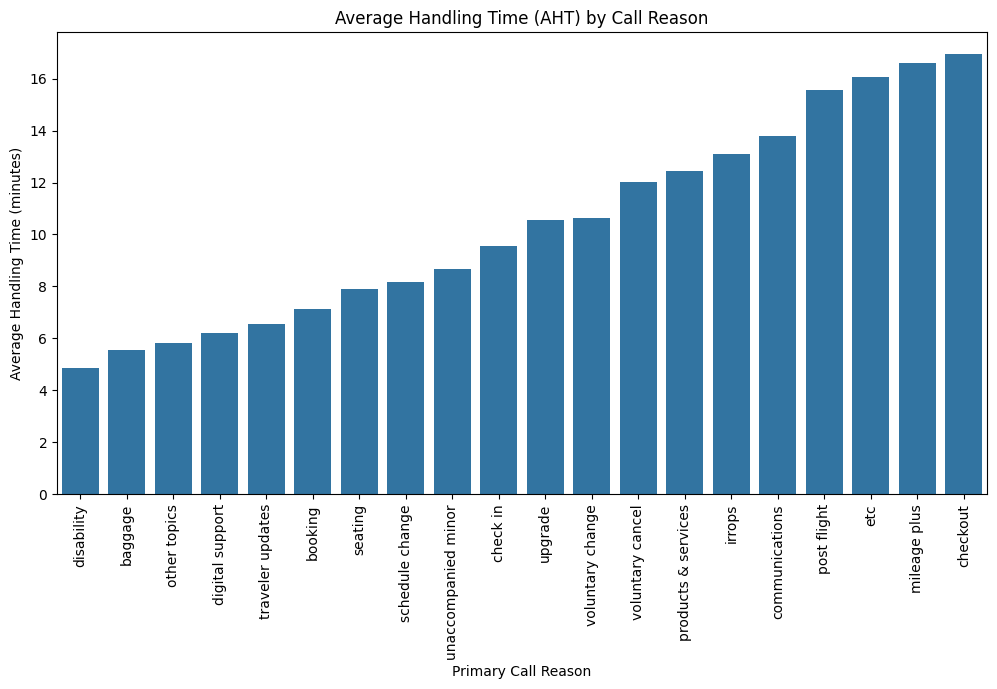

In [24]:
aht_by_reason = merged_data_new.groupby('primary_call_reason_cleaned')['customer_handle_time'].mean().sort_values()
plt.figure(figsize=(12, 6))
sns.barplot(x=aht_by_reason.index, y=aht_by_reason.values)
plt.xticks(rotation=90)
plt.title('Average Handling Time (AHT) by Call Reason')
plt.xlabel('Primary Call Reason')
plt.ylabel('Average Handling Time (minutes)')
plt.show()

<ipython-input-27-9de448872f03>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correlation_data['agent_tone'] = label_encoder.fit_transform(correlation_data['agent_tone'])
<ipython-input-27-9de448872f03>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correlation_data['customer_tone'] = label_encoder.fit_transform(correlation_data['customer_tone'])


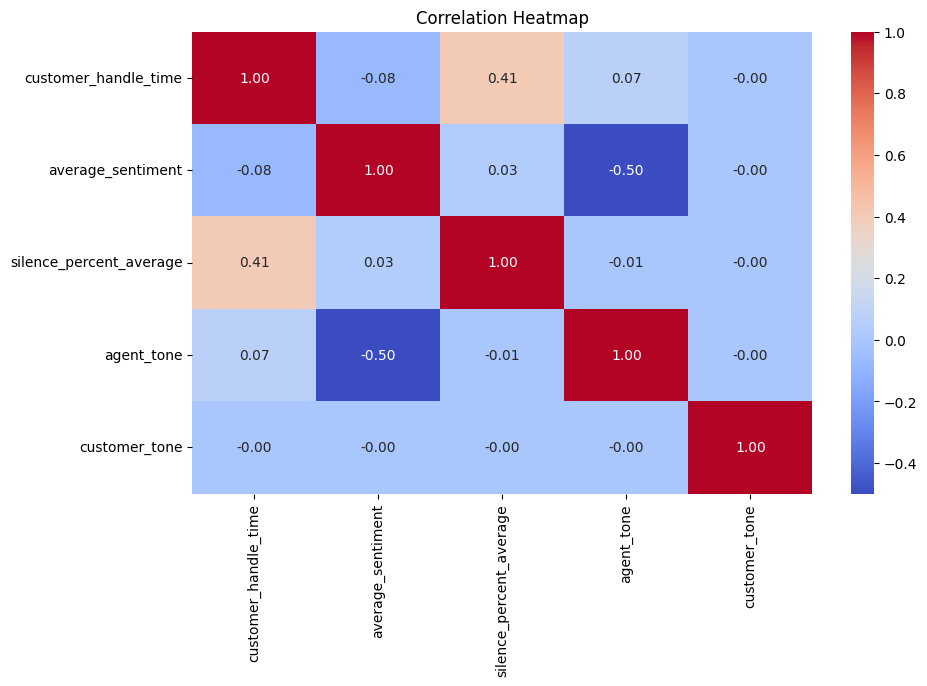

In [27]:
from sklearn.preprocessing import LabelEncoder
correlation_data = merged_data_new[['customer_handle_time', 'average_sentiment', 'silence_percent_average', 'agent_tone', 'customer_tone']]
# Label encoding for categorical variables ('agent_tone' and 'customer_tone')
label_encoder = LabelEncoder()
correlation_data['agent_tone'] = label_encoder.fit_transform(correlation_data['agent_tone'])
correlation_data['customer_tone'] = label_encoder.fit_transform(correlation_data['customer_tone'])

# Calculate the correlation matrix
correlation_matrix = correlation_data.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()
call_type_aht = merged_data_new.groupby('primary_call_reason_cleaned')['customer_handle_time'].mean().sort_values(ascending=False)
call_type_ast = merged_data_new.groupby('primary_call_reason_cleaned')['speed_to_answer'].mean().sort_values(ascending=False)